
# Stock Price Prediction with LSTM (Jupyter Notebook)

**How to use:**  
1. Run the first cell to install required packages.  
2. Adjust the `TICKER` (e.g., `'aapl.us'`, `'msft.us'`, `'goog.us'`, `'amzn.us'`) and optionally `EPOCHS`.  
3. Run all cells top-to-bottom.

**Data source (daily CSV):** Stooq — example for Apple: `https://stooq.com/q/d/l/?s=aapl.us&i=d`  
You can replace `aapl.us` with other tickers that Stooq supports (e.g., `msft.us`, `goog.us`, `amzn.us`).


In [ ]:

# If you're running locally and don't have these, uncomment and run.
# (In some hosted environments, TensorFlow may already be installed.)
# Note: Restart the kernel after install if prompted.
# %pip install --upgrade pip
# %pip install numpy pandas matplotlib scikit-learn tensorflow


In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---- User-configurable settings ----
TICKER = 'aapl.us'   # Try: 'msft.us', 'goog.us', 'amzn.us', etc.
EPOCHS = 20
BATCH_SIZE = 32
WINDOW_SIZE = 60
TEST_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

DATA_URL = f"https://stooq.com/q/d/l/?s={TICKER}&i=d"
print("Data URL:", DATA_URL)


Data URL: https://stooq.com/q/d/l/?s=aapl.us&i=d


In [3]:

# Load daily OHLC from Stooq CSV
df = pd.read_csv(DATA_URL)
df.head()


,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.099605,0.100827,0.098402,0.099605,98811715
1,1984-09-10,0.099605,0.099910,0.097210,0.099014,76694011
2,1984-09-11,0.099910,0.102620,0.099910,0.100827,180849030
3,1984-09-12,0.100827,0.101417,0.097791,0.097791,157987052
4,1984-09-13,0.103232,0.103526,0.103232,0.103232,246058991


        Date      Open      High       Low     Close     Volume
0 1984-09-07  0.099605  0.100827  0.098402  0.099605   98811715
1 1984-09-10  0.099605  0.099910  0.097210  0.099014   76694011
2 1984-09-11  0.099910  0.102620  0.099910  0.100827  180849030
3 1984-09-12  0.100827  0.101417  0.097791  0.097791  157987052
4 1984-09-13  0.103232  0.103526  0.103232  0.103232  246058991


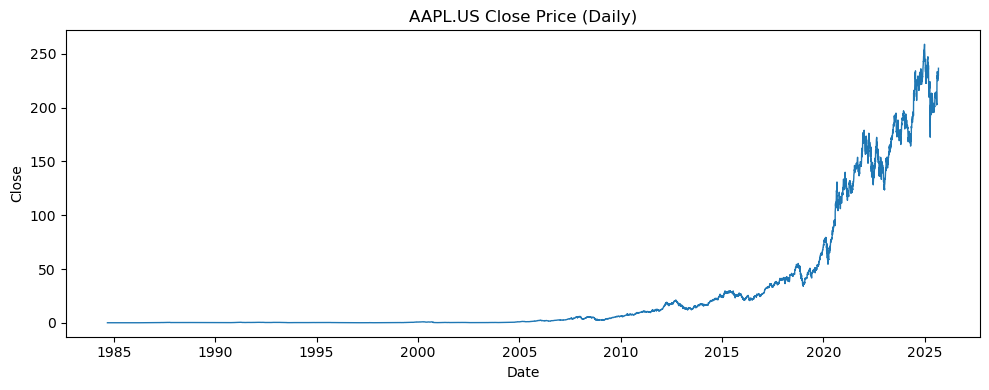

In [5]:
# Ensure consistent column casing (Stooq columns are lowercase by default: date, open, high, low, close, volume)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())


# Plot close price to see the series
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['Close'], linewidth=1)
plt.title(f"{TICKER.upper()} Close Price (Daily)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.tight_layout()
plt.show()


In [7]:

# Use only the 'close' price for univariate forecasting
data = df[['Date','Close']].copy()

# Train/test split by time
split_idx = int(len(data) * (1 - TEST_SPLIT))
train_data = data.iloc[:split_idx].copy()
test_data  = data.iloc[split_idx:].copy()

# Scale close prices to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Close']])
test_scaled  = scaler.transform(test_data[['Close']])

def make_sequences(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_scaled, WINDOW_SIZE)

# For test, we need the last WINDOW_SIZE points from train to create the first window
test_input = np.concatenate([train_scaled[-WINDOW_SIZE:], test_scaled], axis=0)
X_test, y_test = make_sequences(test_input, WINDOW_SIZE)

# Reshape to (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

X_train.shape, X_test.shape


((8201, 60, 1), (2066, 60, 1))

In [8]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

C:\Users\SUBHANUDDIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 6.1185e-04 - val_loss: 0.0030
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 3.0418e-04 - val_loss: 0.0025
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 2.7214e-04 - val_loss: 8.6602e-04
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 2.3617e-04 - val_loss: 9.1085e-04
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 2.0715e-04 - val_loss: 6.5212e-04
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 2.4563e-04 - val_loss: 0.0023
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 2.0247e-04 - val_loss: 9.2388e-04
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 1.8731e-04 - val_loss: 0.0013


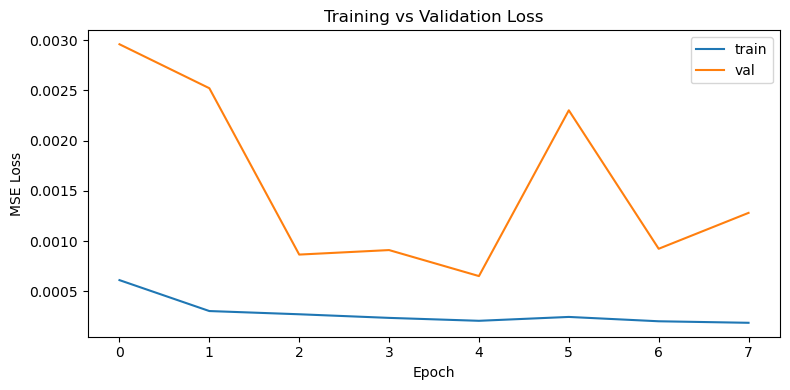

In [9]:

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(['train', 'val'])
plt.tight_layout()
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Test RMSE: 81.338
Test MAE : 63.212
Test MAPE: 39.58%


ValueError: x and y must have same first dimension, but have shapes (2006,) and (2066,)

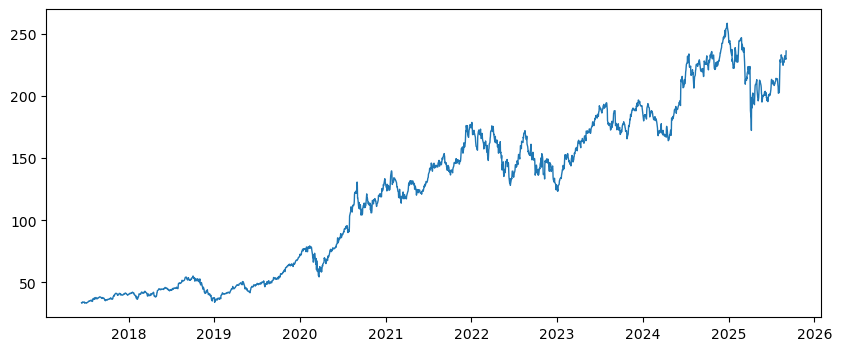

In [16]:

# Predictions (scaled)
pred_scaled = model.predict(X_test)

# Inverse transform
pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# Compute metrics
rmse = math.sqrt(mean_squared_error(y_true, pred))
mae  = mean_absolute_error(y_true, pred)
mape = np.mean(np.abs((y_true - pred) / y_true)) * 100

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE : {mae:.3f}")
print(f"Test MAPE: {mape:.2f}%")
# Align predictions with correct test dates
test_dates = data['Date'].iloc[len(train_data):].reset_index(drop=True)
pred_dates = test_dates.iloc[WINDOW_SIZE:].reset_index(drop=True)  # shift by WINDOW_SIZE

# Now pred and pred_dates have the same length
plt.figure(figsize=(10, 4))
plt.plot(test_dates, test_data['Close'].values, linewidth=1, label='Actual (Test)')
plt.plot(pred_dates, pred.flatten(), linewidth=2, label='Predicted')
plt.title(f"{TICKER.upper()} — Actual vs Predicted (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:

N_STEPS_AHEAD = 7

last_window = test_input[-WINDOW_SIZE:].copy()  # scaled last window
forecast_scaled = []

for _ in range(N_STEPS_AHEAD):
    x = last_window.reshape(1, WINDOW_SIZE, 1)
    next_scaled = model.predict(x, verbose=0)[0][0]
    forecast_scaled.append(next_scaled)
    # slide the window forward
    last_window = np.append(last_window[1:], [[next_scaled]], axis=0)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1)).flatten()

# Create future dates (business days)
last_date = data['date'].iloc[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=N_STEPS_AHEAD)

# Show forecast
forecast_df = pd.DataFrame({'date': future_dates, 'forecast_close': forecast})
print(forecast_df)

# Plot recent actuals + forecast
lookback_plot = 200  # plot the last ~200 actual points for context
plt.figure(figsize=(10, 4))
plt.plot(data['date'].iloc[-lookback_plot:], data['close'].iloc[-lookback_plot:], linewidth=1, label='Recent Actual Close')
plt.plot(forecast_df['date'], forecast_df['forecast_close'], linewidth=1, marker='o', label=f'Next {N_STEPS_AHEAD}-Day Forecast')
plt.title(f"{TICKER.upper()} — Recent Close & {N_STEPS_AHEAD}-Day LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'date'

In [ ]:

# Optional: save the trained model
# model.save(f"{TICKER.replace('.', '_')}_lstm_model.keras")
# print("Model saved.")
